# FREDtools Tutorial

Basic functionalities of FREDtools are presented in this document. It has been prepared to help to start with data analysis using FREDtools. Refer to the FREDtools [documentation](https://fredtools.ifj.edu.pl) and [GitHub repository](https://github.com/jasqs/FREDtools) for more details. Any requests and issues are welcome by starting a new issue on the GitHub.

The examples below are prepared based on files available in the examples/exampleData.zip file on GitHub. Download the file and unzip it in the same folder as this jupyter notebook. The file contains:

- dicom files of a CT scan of a CIRS head phantom ([www.cirsinc.com](https://www.cirsinc.com/products/radiation-therapy/proton-therapy-dosimetry-head/)) made with a Siemens CT scanner.
- dicom file of a treatment plan with scanning proton beam prepared in Varian Eclipse v 15.6 treatment planning system. The plan consists of two fields irradiating 'PTV_sphere' planning structure with 70 Gy(RBE) in 35 fractions. Please consider, that this is a simple treatment plan prepared on a phantom CT scan and does not need to be clinically sensible for the purpose of this example.
- dicom file with structures. It contains several regular an irregular structures used for testing.
- dicom files with dose for each field separately. The dose was calculated by the treatment planning system with a pencil beam algorithm and is saved in Gy(RBE) with RBE=1.1.


Note that only the basic functionality is presented here and remember that most of the functions have a `displayInfo` (def. False) parameter to display basic information about the results of the function. 

In [1]:
# Import of FREDtools and other useful modules
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk


import fredtools as ft

print("Current FREDtools version", ft.__version__)


Current FREDtools version 0.6.41


## Reading dicoms 

In this section it is presented how to read different types of dicom files.

In [2]:
# get absolute paths to dicoms in the exampleData folder
fileNames=ft.sortDicoms('exampleData/', recursive=True, displayInfo=True)

# get RN dicom plan info
planInfo=ft.getRNInfo(fileNames['RNfileNames'][0], displayInfo=True)

# get CT from dicoms
imgCT=ft.getCT(fileNames['CTfileNames'], displayInfo=True) # the imgCT is an instance of SimpleITK object

# read dose from RD dicoms for each field
imgDose=ft.getRD(fileNames['RDfileNames']) # there are two dicoms with dose, so imgDose will be a list of SimpleITK objects

# sum dose for images in the list
imgDose=ft.sumImg(imgDose, displayInfo=True)

# get RS structure dicom info
structInfo=ft.getRSInfo(fileNames['RSfileNames'][0], displayInfo=True) # the structInfo is a pandas DataFrame

### sortDicoms ###
# Found dicoms: 240 x CT, 1 x RS, 1 x RN, 2 x RD, 0 x unknown
##################
### getRNInfo ###
# Patient name:     'RASISndwYCjIhgDE'
# Plan label:       'Sphere_2F'
# Plan date:        '20210702'
# Machine name:     'GTR4'
# Target structure: ''
# Number of fractions: 35
# Dose pres. (all fractions):    70.000 Gy RBE
# Dose pres. (single fraction):  2.000 Gy RBE
# Number of treatment fields: 2
# Number of setup fields:     0
#################
### getCT ###
# 3D image describing volume (3D)
# dims (xyz) =  [512 512 240]
# voxel size [mm] =  [0.9765625 0.9765625 1.2      ]
# origin [mm]     =  [-249.51171875 -470.51171875 -718.3       ]
# x-spatial voxel centre [mm] =  [  -249.511719,  -248.535156, ...,   248.535156,   249.511719 ]
# y-spatial voxel centre [mm] =  [  -470.511719,  -469.535156, ...,    27.535156,    28.511719 ]
# z-spatial voxel centre [mm] =  [  -718.300000,  -717.100000, ...,  -432.700000,  -431.500000 ]
# x-spatial extent [mm] =  [  -250.000000 

## Image manipulation

Below it is presented how to manipulate with the images being instances of SimpleITK objects.  

In [3]:
# get name of the structure of type EXTERNAL (usually only one strycture of type EXTERNAL exists in RTstructure dicom)
structNameEXTERNAL=ft.getExternalName(fileNames['RSfileNames'][0], displayInfo=True)

# map EXTERNAL structure to CT image (create a mask)
imgROIExt=ft.mapStructToImg(imgCT, RSfileName=fileNames['RSfileNames'][0], structName=structNameEXTERNAL)

# set values of the CT image outside EXTERNAL structure to HU=-1000 (air)
imgCTmod=ft.setValueMask(imgCT, imgMask=imgROIExt, value=-1000, outside=True)

# crop CT image to EXTERNAL structure
imgCTCrop=ft.cropImgToMask(imgCTmod, imgMask=imgROIExt)

# resample CT image to voxel size 1.5x1.5x1.5 mm
imgCTRes=ft.resampleImg(imgCTCrop, spacing=[1.5,1.5,1.5], interpolation='linear')


### getExternalName ###
# ROI name of type EXTERNAL: 'External'
#######################


In [4]:
# map more structures to the cropped CT image
imgROIExt=ft.mapStructToImg(imgCTCrop, RSfileName=fileNames['RSfileNames'][0], structName=structNameEXTERNAL)
imgROISphere=ft.mapStructToImg(imgCTCrop, RSfileName=fileNames['RSfileNames'][0], structName='PTV_sphere')
imgROIMix=ft.mapStructToImg(imgCTCrop, RSfileName=fileNames['RSfileNames'][0], structName='testStuct_SphHoleDet')
# check 'structInfo' variable to check available structures

## Saving image

Now the images can be saved/read to/from MHD files. This format is often used by Monte Carlo engines like [FRED](http://fred-mc.org/) or [Gate](http://www.opengatecollaboration.org/).

In [5]:
# write original CT, the cropped CT and the rescaled CT 
ft.writeMHD(imgCT, 'CT.mhd')
ft.writeMHD(imgCTCrop, 'CTCrop.mhd')
ft.writeMHD(imgCTRes, 'CTRes.mhd')

# write ROI masks (mapped structures)
ft.writeMHD(imgROIExt, 'ROI_External.mhd')
ft.writeMHD(imgROISphere, 'ROI_Sphere.mhd')
ft.writeMHD(imgROIMix, 'ROI_Mix.mhd')


# read the images back
imgCT=ft.readMHD('CT.mhd', displayInfo=True)
imgCTCrop=ft.readMHD('CTCrop.mhd', displayInfo=True)
imgCTRes=ft.readMHD('CTRes.mhd', displayInfo=True)


### readMHD ###
# 3D image describing volume (3D)
# dims (xyz) =  [512 512 240]
# voxel size [mm] =  [0.9765625 0.9765625 1.2      ]
# origin [mm]     =  [-249.51171875 -470.51171875 -718.3       ]
# x-spatial voxel centre [mm] =  [  -249.511719,  -248.535156, ...,   248.535156,   249.511719 ]
# y-spatial voxel centre [mm] =  [  -470.511719,  -469.535156, ...,    27.535156,    28.511719 ]
# z-spatial voxel centre [mm] =  [  -718.300000,  -717.100000, ...,  -432.700000,  -431.500000 ]
# x-spatial extent [mm] =  [  -250.000000 ,   250.000000 ] =>   500.000000
# y-spatial extent [mm] =  [  -471.000000 ,    29.000000 ] =>   500.000000
# z-spatial extent [mm] =  [  -718.900000 ,  -430.900000 ] =>   288.000000
# volume = 72000000.00 mm3  =>  72.00 l
# voxel volume = 1.14 mm3  =>  1.14 ul
# data type:  16-bit signed integer 
# range: from  -1000  to  3071 
# sum = -56224874921 , mean = -893.670319255193 ( 313.7877619691319 ) 
# non-zero (dose=0)  voxels  = 62902798 (99.98%) => 71.99 l 
# non-

## Image analysis and displaying 

Some functionalities for image analysis and displaying are presented below. 

#### Example 1 - getting subimages and displaying

### readMHD ###
# 3D image describing volume (3D)
# dims (xyz) =  [238 294 240]
# voxel size [mm] =  [0.9765625 0.9765625 1.2      ]
# origin [mm]     =  [-113.76953125 -356.25390625 -718.3       ]
# x-spatial voxel centre [mm] =  [  -113.769531,  -112.792969, ...,   116.699219,   117.675781 ]
# y-spatial voxel centre [mm] =  [  -356.253906,  -355.277344, ...,   -71.097656,   -70.121094 ]
# z-spatial voxel centre [mm] =  [  -718.300000,  -717.100000, ...,  -432.700000,  -431.500000 ]
# x-spatial extent [mm] =  [  -114.257812 ,   118.164062 ] =>   232.421875
# y-spatial extent [mm] =  [  -356.742188 ,   -69.632812 ] =>   287.109375
# z-spatial extent [mm] =  [  -718.900000 ,  -430.900000 ] =>   288.000000
# volume = 19218383.79 mm3  =>  19.22 l
# voxel volume = 1.14 mm3  =>  1.14 ul
# data type:  16-bit signed integer 
# range: from  -1000  to  3071 
# sum = -11546690452 , mean = -687.5780343089617 ( 504.47348617159315 ) 
# non-zero (dose=0)  voxels  = 16781906 (99.93%) => 19.21 l 
# no

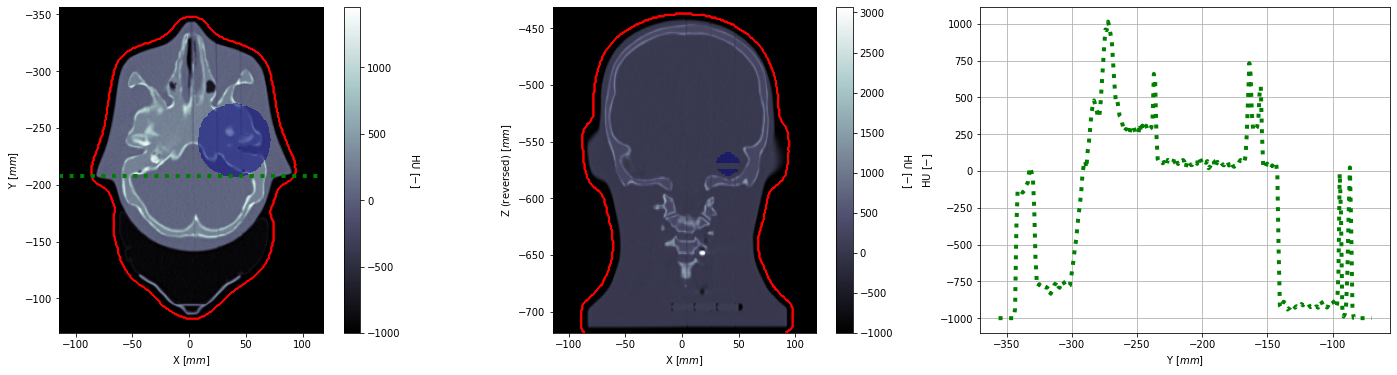

In [6]:
# read CT and masks for structures
imgCTCrop=ft.readMHD('CTCrop.mhd', displayInfo=True)
imgROIExt=ft.readMHD('ROI_External.mhd', displayInfo=True)
imgROIMix=ft.readMHD('ROI_Mix.mhd', displayInfo=True)

#get CT centre of mass
centreOfMassPoint=ft.getMassCenter(imgCTCrop, displayInfo=True)

# gerenate CT cross-sections through the image centre of mass
slCTXY=ft.getSlice(imgCTCrop, point=centreOfMassPoint, plane='XY')
slCTXZ=ft.getSlice(imgCTCrop, point=centreOfMassPoint, plane='X-Z') # refer to documentation about the 'X-Z' notation

# gerenate EXTERNAL mask cross-sections through the image centre of mass
slROIExtXY=ft.getSlice(imgROIExt, point=centreOfMassPoint, plane='XY', interpolation='nearest')
slROIExtXZ=ft.getSlice(imgROIExt, point=centreOfMassPoint, plane='X-Z', interpolation='nearest')

# gerenate 'testStuct_SphHoleDet' mask cross-sections through the image centre of mass
slROIMixXY=ft.getSlice(imgROIMix, point=centreOfMassPoint, plane='XY', interpolation='nearest')
slROIMixXZ=ft.getSlice(imgROIMix, point=centreOfMassPoint, plane='X-Z', interpolation='nearest')

# assign nan values (will not be displayed) for zeros in the 'testStuct_SphHoleDet' image mask
# unfortunately the np.nan values can be used only for float images.
slROIMixXY=sitk.Cast(slROIMixXY, sitk.sitkFloat32) # change the image mask to float
slROIMixXZ=sitk.Cast(slROIMixXZ, sitk.sitkFloat32) # change the image mask to float
slROIMixXY=sitk.Threshold(slROIMixXY, lower=1, upper=10, outsideValue=np.nan)
slROIMixXZ=sitk.Threshold(slROIMixXZ, lower=1, upper=10, outsideValue=np.nan)

# generate line profiles through the image centre of mass along Y direction
slCTX=ft.getProfile(imgCTCrop, point=centreOfMassPoint, axis='Y')

# plot results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=[25,6])


im=ax1.imshow(ft.arr(slCTXY), extent=ft.getExtMpl(slCTXY), cmap='bone')
ax1.imshow(ft.arr(slROIMixXY), extent=ft.getExtMpl(slROIMixXY), alpha=0.5, cmap='jet') # show the mapped structure as area
ax1.contour(ft.arr(slROIExtXY), extent=ft.getExtMpl(slROIExtXY), colors='r', linewidths=1, origin='upper') # show the mapped structure as contour
cbar=plt.colorbar(im, ax=ax1)
cbar.set_label('HU [$-$]', rotation=270, labelpad=20)
ax1.axhline(centreOfMassPoint[1], ls=':', c='g', lw=4) # draw horizontal line at Y coordinate of the image centre of mass 
ax1.set_xlabel('X [$mm$]')
ax1.set_ylabel('Y [$mm$]')


im=ax2.imshow(ft.arr(slCTXZ), extent=ft.getExtMpl(slCTXZ), cmap='bone')
ax2.imshow(ft.arr(slROIMixXZ), extent=ft.getExtMpl(slROIMixXZ), alpha=0.5, cmap='jet') # show the mapped structure as area
ax2.contour(ft.arr(slROIExtXZ), extent=ft.getExtMpl(slROIExtXZ), colors='r', linewidths=1, origin='upper') # show the mapped structure as contour
cbar=plt.colorbar(im, ax=ax2)
cbar.set_label('HU [$-$]', rotation=270, labelpad=20)
ax2.set_xlabel('X [$mm$]')
ax2.set_ylabel('Z (reversed) [$mm$]')

ax3.plot(ft.pos(slCTX), ft.vec(slCTX), 'g:', lw=4)
ax3.set_xlabel('Y [$mm$]')
ax3.set_ylabel('HU [$-$]')
ax3.grid()

#### Example 2 - DVH analysis and displaying

### getDVH ###
# Structure name: 'PTV_sphere'
# Prescribed dose: 70.000 Gy
# Volume: 90.030 cm3
# Dose max/min: 76.010/67.140 Gy
# Dose mean: 72.442 Gy
# Absolute HI (D02-D98): 4.350 Gy
# D98: 70.030 Gy
# D50: 72.520 Gy
# D02: 74.380 Gy
##############
### getDVH ###
# Structure name: 'testStuct_SphHoleDet'
# Prescribed dose: 70.000 Gy
# Volume: 138.060 cm3
# Dose max/min: 76.010/48.650 Gy
# Dose mean: 69.811 Gy
# Absolute HI (D02-D98): 15.500 Gy
# D98: 58.630 Gy
# D50: 71.480 Gy
# D02: 74.130 Gy
##############
### getDVH ###
# Structure name: 'testStruct_small'
# Prescribed dose: 70.000 Gy
# Volume: 0.500 cm3
# Dose max/min: 72.600/33.410 Gy
# Dose mean: 59.065 Gy
# Absolute HI (D02-D98): 33.350 Gy
# D98: 38.440 Gy
# D50: 61.050 Gy
# D02: 71.790 Gy
##############
#########################################################################
D95 parameter for dose in 'testStuct_SphHoleDet' structure : 61.23 Gy(RBE)
V50 parameter for dose in 'testStruct_small' structure : 0.50 cm3
Homogeneity

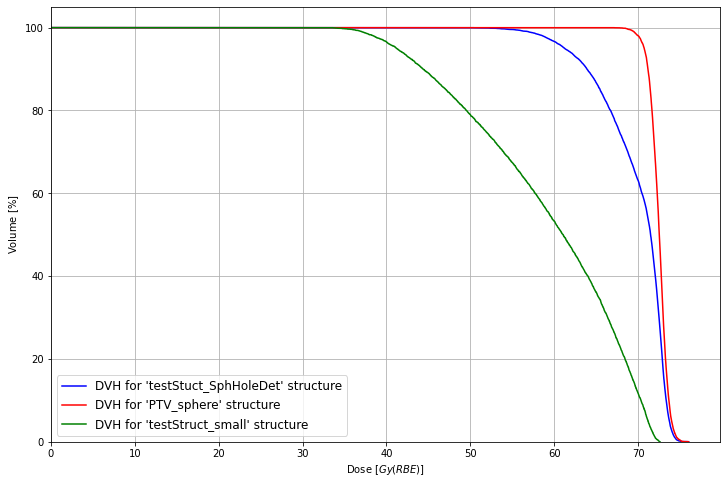

In [7]:
# get absolute paths to dicoms in the exampleData folder
fileNames=ft.sortDicoms('exampleData/', recursive=True)

# get RN dicom plan info
planInfo=ft.getRNInfo(fileNames['RNfileNames'][0])

# get CT from dicoms
imgCT=ft.getCT(fileNames['CTfileNames']) # the imgCT is an instance of SimpleITK object

# read dose from RD dicoms for each field
imgDose=ft.getRD(fileNames['RDfileNames']) # there are two dicoms with dose, so imgDose will be a list of SimpleITK objects

# sum dose for images in the list
imgDose=ft.sumImg(imgDose)

# get RS structure dicom info
structInfo=ft.getRSInfo(fileNames['RSfileNames'][0]) # the structInfo is a pandas DataFrame
structInfo

# calculate DVHs for structures
dvhPTV_sphere=ft.getDVH(img=imgDose, 
                        RSfileName=fileNames['RSfileNames'][0], 
                        structName='PTV_sphere', 
                        dosePrescribed=planInfo['dosePrescribed'], 
                        displayInfo=True)

dvhtestStuct_SphHoleDet=ft.getDVH(img=imgDose, 
                                  RSfileName=fileNames['RSfileNames'][0], 
                                  structName='testStuct_SphHoleDet', 
                                  dosePrescribed=planInfo['dosePrescribed'], 
                                  displayInfo=True)

dvhtestStruct_small=ft.getDVH(img=imgDose, 
                              RSfileName=fileNames['RSfileNames'][0], 
                              structName='testStruct_small', 
                              dosePrescribed=planInfo['dosePrescribed'], 
                              resampleImg=0.5, # for small structures it is recommended to resample the dose image to smaller voxel size (0.5x0.5x0.5 mm3 in this case)
                              displayInfo=True)

# get dosimetric parameters from DVHs
"""
The Homogeneity Index (HI) is defined as (D02-D98)/Dpres. Refer to https://doi.org/10.3389/fphy.2020.567300 for more information
"""
print("#########################################################################")
print("D95 parameter for dose in 'testStuct_SphHoleDet' structure : {:.2f} Gy(RBE)".format(dvhtestStuct_SphHoleDet.statistic('D95').value))
print("V50 parameter for dose in 'testStruct_small' structure : {:.2f} cm3".format(dvhtestStruct_small.statistic('V50').value))
HI=(dvhPTV_sphere.statistic('D02').value-dvhPTV_sphere.statistic('D98').value)/dvhPTV_sphere.rx_dose 
print(f"Homogeneity Index for the dose in 'PTV_sphere' : {HI:.3f}")
print("#########################################################################")

# plot DVHs
fig, ax = plt.subplots(figsize=[12, 8])

ax.plot(dvhtestStuct_SphHoleDet.bincenters, dvhtestStuct_SphHoleDet.counts/dvhtestStuct_SphHoleDet.volume*100, "-b", label="DVH for 'testStuct_SphHoleDet' structure")
ax.plot(dvhPTV_sphere.bincenters, dvhPTV_sphere.counts/dvhPTV_sphere.volume*100, "-r", label="DVH for 'PTV_sphere' structure")
ax.plot(dvhtestStruct_small.bincenters, dvhtestStruct_small.counts/dvhtestStruct_small.volume*100, "-g", label="DVH for 'testStruct_small' structure")
ax.set_xlim(0,)
ax.set_ylim(0,)
ax.set_xlabel("Dose [$Gy(RBE)$]")
ax.set_ylabel("Volume [$\%$]")
ax.grid()
ax.legend(fontsize=12)

## More about image manipulation

As mentioned above, all the images are instances of a SimpleITK image object. All the functionalities and filters available in the SimpleITK module can be used with the images. Refer to [simpleitk.readthedocs.io](https://simpleitk.readthedocs.io/en/v2.0.0/filters.html) for available filters and [insightsoftwareconsortium](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/) for segmentation, registration and other examples. Below, examples of basic functionalities are presented.  

#### Example 3 (SimpleITK filters)

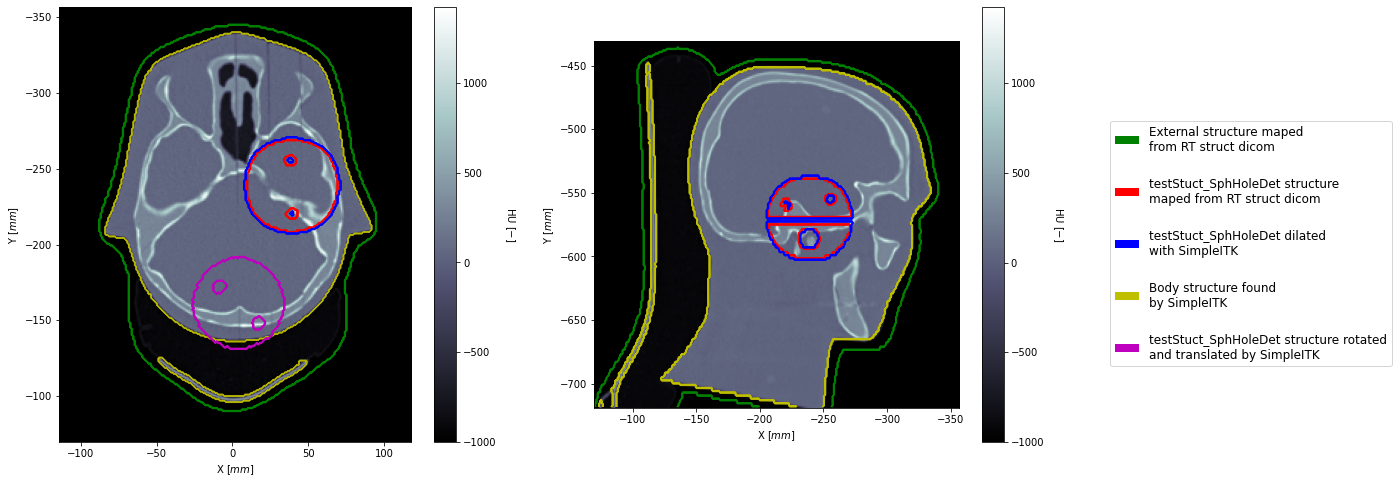

In [8]:
# read CT and masks for structures
imgCTCrop=ft.readMHD('CTCrop.mhd')
imgROIMix=ft.readMHD('ROI_Mix.mhd')
imgROIExt=ft.readMHD('ROI_External.mhd')

####### Example 3a
"""
Binary dilation of image describing a mask for 'Mix' contour (contourName='testStuct_SphHoleDet').
refer to: https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1BinaryDilateImageFilter.html
"""
imgROIMixDilated=sitk.BinaryDilate(imgROIMix, [1,1,1])

####### Example 3b
"""
Find body mask based on CT values
"""
imgROIBody=sitk.BinaryThreshold(imgCTCrop, # the 'Body' should be all inside 'External' 
                                lowerThreshold=-800, 
                                upperThreshold=int(ft.arr(imgCT).max()) # upper threshold is set to the maximum CT value
                               )
imgROIBody=sitk.BinaryFillhole(imgROIBody) # fill small holes in the 'Body' mask
imgROIBody=sitk.BinaryMorphologicalOpening(imgROIBody, kernelRadius=[1,1,1]) # remove small volumes outside the main 'Body' mask

####### Example 3c
"""
Translate and rotate image using SimpleITK Euler3DTransform.
fixed centre: centre of mass of the image 
rotation: 45 deg around Z direction
translation: vector [80, -30, 0] in mm
"""
Euler3DTransform=sitk.Euler3DTransform(ft.getMassCenter(imgROIMix), 0, 0, np.deg2rad(45), [80,-30,0])
imgROIMixTransform=sitk.Resample(imgROIMix, transform=Euler3DTransform, interpolator=ft.ft_imgGetSubimg._setSITKInterpolator('linear'))


###### plot results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[18,8])
slicePoint=[40, -210, -557.5] # set point in 3D to generate slices through

# gerenate cross-sections through the slicePoint
plane='XY'
slCT=ft.getSlice(imgCTCrop, point=slicePoint, plane=plane)
slROIExt=ft.getSlice(imgROIExt, point=slicePoint, plane=plane)
slROIMix=ft.getSlice(imgROIMix, point=slicePoint, plane=plane)
slROIMixDilated=ft.getSlice(imgROIMixDilated, point=slicePoint, plane=plane)
slROIBody=ft.getSlice(imgROIBody, point=slicePoint, plane=plane)
slROIMixTransform=ft.getSlice(imgROIMixTransform, point=slicePoint, plane=plane)

im=ax1.imshow(ft.arr(slCT), extent=ft.getExtMpl(slCT), cmap='bone')
ax1.contour(ft.arr(slROIExt), extent=ft.getExtMpl(slROIExt), colors='g', linewidths=1, linestyles='-', origin='upper')
ax1.contour(ft.arr(slROIMix), extent=ft.getExtMpl(slROIMix), colors='r', linewidths=1, linestyles='-', origin='upper')
ax1.contour(ft.arr(slROIMixDilated), extent=ft.getExtMpl(slROIMixDilated), colors='b', linewidths=1, linestyles='-', origin='upper')
ax1.contour(ft.arr(slROIBody), extent=ft.getExtMpl(slROIBody), colors='y', linewidths=0.5, linestyles='-', origin='upper')
ax1.contour(ft.arr(slROIMixTransform), extent=ft.getExtMpl(slROIMixTransform), colors='m', linewidths=1, linestyles='-', origin='upper')
cbar=plt.colorbar(im, ax=ax1)
cbar.set_label('HU [$-$]', rotation=270, labelpad=20)
ax1.set_xlabel('X [$mm$]')
ax1.set_ylabel('Y [$mm$]')


# gerenate cross-sections through the slicePoint
plane='-Y-Z'
slCT=ft.getSlice(imgCTCrop, point=slicePoint, plane=plane)
slROIExt=ft.getSlice(imgROIExt, point=slicePoint, plane=plane)
slROIMix=ft.getSlice(imgROIMix, point=slicePoint, plane=plane)
slROIMixDilated=ft.getSlice(imgROIMixDilated, point=slicePoint, plane=plane)
slROIBody=ft.getSlice(imgROIBody, point=slicePoint, plane=plane)

im=ax2.imshow(ft.arr(slCT), extent=ft.getExtMpl(slCT), cmap='bone')
csROIExt=ax2.contour(ft.arr(slROIExt), extent=ft.getExtMpl(slROIExt), colors='g', linewidths=1, linestyles='-', origin='upper')
ax2.contour(ft.arr(slROIMix), extent=ft.getExtMpl(slROIMix), colors='r', linewidths=1, linestyles='-', origin='upper')
ax2.contour(ft.arr(slROIMixDilated), extent=ft.getExtMpl(slROIMixDilated), colors='b', linewidths=1, linestyles='-', origin='upper')
ax2.contour(ft.arr(slROIBody), extent=ft.getExtMpl(slROIBody), colors='y', linewidths=1, linestyles='-', origin='upper')
cbar=plt.colorbar(im, ax=ax2)
cbar.set_label('HU [$-$]', rotation=270, labelpad=20)
ax2.set_xlabel('X [$mm$]')
ax2.set_ylabel('Y [$mm$]')

# make legend
legendRect = [plt.Rectangle((1, 1), 2, 2, fc=color) for color in ['g','r','b','y','m']]
ax2.legend(legendRect, ["External structure maped\nfrom RT struct dicom", 
                        "testStuct_SphHoleDet structure\nmaped from RT struct dicom", 
                        "testStuct_SphHoleDet dilated\nwith SimpleITK", 
                        "Body structure found\nby SimpleITK",
                        "testStuct_SphHoleDet structure rotated\nand translated by SimpleITK"], 
           bbox_to_anchor=(2.2, 0.8), labelspacing=2, fontsize=12)

## Display Images

A few simple functions are implemented in FREDtools to allow for a quick view of the images, also in an interactive mode. See [Jupyter notebook of Image Display Tutorial](https://github.com/jasqs/FREDtools/blob/main/examples/Image%20Display%20Tutorial.ipynb) for more details.

In [9]:
### read again the dose and the CT images, as well as the plan info

# read dose from RD dicoms for each field
imgDose = ft.getRD(fileNames["RDfileNames"])  # there are two dicoms with dose, so imgDose will be a list of SimpleITK objects

# get CT from dicoms
imgCT = ft.getCT(fileNames["CTfileNames"])

# get plan info
planInfo = ft.getRNInfo(fileNames["RNfileNames"][0])

# get fields info
fieldsInfo =  ft.getRNFields(fileNames["RNfileNames"][0], displayInfo=True)

# # sum dose for images in the list
# imgDose=ft.sumImg(imgDose, displayInfo=True)

# map PTV roi to CT
imgROI_PTV = ft.mapStructToImg(imgCT, RSfileName=fileNames["RSfileNames"][0], structName="PTV_sphere")

### getRNFields ###


,FNo,FName,FGantryAngle,FCouchAngle,FCouchPitchAngle,FCouchRollAngle,FIsoPos,FRSID,FSnoutPos,FEnergyNo,FEnergyMin,FEnergyMax,FSpotNo,FDose,FMU,FMagDist,FCumMsW,FsupportID
FDeliveryNo,,,,,,,,,,,,,,,,,,
1,1,Field 1,0.0,0.0,0.0,0.0,"[39.3807283826884, -238.93381359307, -570.1203...",RS_Block,430.0,25,106.982,164.808,1132,1.0,255.680850,"[2215.0, 1846.0]",254.185117,ProtonTable
2,2,Field 2,90.0,0.0,0.0,0.0,"[39.3807283826884, -238.93381359307, -570.1203...",RS_Block,430.0,29,79.602,135.998,2073,1.0,309.247479,"[2215.0, 1846.0]",307.438382,ProtonTable


###################


In [10]:
# display dose of the field 1 overlapped on the CT
fieldNo=1
ft.showSlices(imgCT=imgCT, imgDose=imgDose[field], imgROIs=imgROI_PTV, point=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FIsoPos"].iloc[0], figsize=[21,7], interactive=False)

NameError: name 'field' is not defined

In [ ]:
# display dose for all fields overlapped on the CT
ft.showSlices(imgCT=imgCT, imgDose=ft.sumImg(imgDose), imgROIs=imgROI_PTV, point=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FIsoPos"].iloc[0], interactive=False)

In [ ]:
# display beam's eye view of the field 1
fieldNo=1

imgDoseBEVF1=ft.getImgBEV( ft.sumImg(imgDose), 
                           isocentrePosition=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FIsoPos"].iloc[0], 
                           gantryAngle=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FGantryAngle"].iloc[0], 
                           couchAngle=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FCouchAngle"].iloc[0])
imgCTBEVF1  =ft.getImgBEV(imgCT, 
                           isocentrePosition=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FIsoPos"].iloc[0], 
                           gantryAngle=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FGantryAngle"].iloc[0], 
                           couchAngle=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FCouchAngle"].iloc[0])
imgROI_PTV_BEVF1 =ft.getImgBEV(imgROI_PTV, 
                                isocentrePosition=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FIsoPos"].iloc[0], 
                                gantryAngle=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FGantryAngle"].iloc[0], 
                                couchAngle=fieldsInfo.loc[fieldsInfo.FNo==fieldNo, "FCouchAngle"].iloc[0])

ft.showSlices(imgCT=imgCTBEVF1, imgDose=imgDoseBEVF1, imgROIs=imgROI_PTV_BEVF1, point=[0,0,0], interactive=False)